In [54]:
from dotenv import load_dotenv
from typing import Dict, List, Any, Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langsmith import traceable
from langgraph.types import interrupt, Command
from langgraph.graph import MessagesState

from uuid import uuid4
load_dotenv()

True

In [55]:
fnol_text = """John Doe (insured) reported a water loss on 02/20/2025 at 09:12 AM.
Policy Number: HO3-77889900
Email: john.doe@example.com

Loss occurred on 02/19/2025 around 2:35 PM.

Insured states the supply line under the upstairs bathroom sink burst
while no one was home. Water leaked through the floor into the living room,
causing damage to the ceiling and flooring.

Mitigation performed:
- Main water valve shut off
- Emergency plumber replaced failed supply line
- Buckets/towels used to contain water
- Fans run overnight

No injuries. Ceiling sagging slightly—minor hazard.
Insured available for inspections most mornings.

Weather: light rain but unrelated to cause.

Insured unsure about home warranty coverage. No prior issues reported.
Photos not yet provided."""

In [57]:
# Tools
@tool
def get_claim_info(claim_id: str) -> str:
    """
    Get claim information by claim id
    """
    fake_claim = {
        "claimId": "CLM-2025-001234",
        "policyNumber": "HO3-77889900",
        "insured": {
            "firstName": "John",
            "lastName": "Doe",
            "phone": "+1-555-238-9021",
            "email": "john.doe@example.com",
            "address": {
                "street": "1245 Westbrook Ave",
                "city": "Austin",
                "state": "TX",
                "zip": "78704"
            }
        },
        "property": {
            "propertyId": "PROP-100178",
            "address": {
                "street": "1245 Westbrook Ave",
                "city": "Austin",
                "state": "TX",
                "zip": "78704"
            },
            "type": "Single Family Home",
            "yearBuilt": 1997,
            "squareFeet": 2650,
            "roofType": "Composition Shingle",
            "numStories": 2,
            "hasBasement": False
        },
        "lossInfo": {
            "dateOfLoss": "2025-02-19T14:35:00",
            "reportedDate": "2025-02-20T09:12:00",
            "causeOfLoss": "Water Damage",
            "description": (
                "Insured reported water leaking from upstairs bathroom resulting "
                "in ceiling damage to living room."
            ),
            "mitigationSteps": [
                "Shut off main water valve",
                "Called emergency plumber",
                "Placed buckets to control leaking"
            ]
        },
        "coverage": {
            "coverageA_dwellingLimit": 350000,
            "coverageC_contentsLimit": 90000,
            "deductible": 2500,
            "policyEffective": "2024-06-01",
            "policyExpiration": "2025-06-01"
        },
        "inspection": {
            "inspectionScheduled": True,
            "inspectionDate": "2025-02-22T10:00:00",
            "inspectorName": "Sarah Mitchell"
        },
        "damageAssessment": {
            "roomsAffected": ["Living Room", "Upstairs Bathroom"],
            "estimatedRepairCost": 12840.75,
            "depreciationApplied": 950.00,
            "rcv": 12840.75,
            "acv": 11890.75
        },
        "payments": {
            "initialPaymentIssued": False,
            "amountIssued": 0.0
        },
        "status": "In Review"
    }
    return fake_claim

@tool
def send_email(email: str, subject: str, body: str) -> str:
    """
    Send an email
    """

    decision = interrupt(
        {
            "action": "send_email",
            "email": email,
            "subject": subject,
            "body": body,
        }
    )

    if isinstance(decision, dict):
        if decision.get("approved"):
            subject = decision.get("subject", subject)
            body = decision.get("body", body)
            print(f"Email sent: {email} with subject {subject} and body {body}")
            return f"Email sent: {email} with subject {subject} and body {body}"
    print(f"Email to {email} not sent")
    return f"Email to {email} not sent"


@tool
def get_policy_info(policy_number: str) -> str:
    """
    Get policy information by policy number
    """
    fake_policy = {
        "policyNumber": "HO3-77889900",
        "policyType": "HO-3 Homeowners",
        "insured": {
            "insuredId": "INS-552211",
            "firstName": "John",
            "lastName": "Doe",
            "phone": "+1-555-238-9021",
            "email": "john.doe@example.com",
            "mailingAddress": {
                "street": "1245 Westbrook Ave",
                "city": "Austin",
                "state": "TX",
                "zip": "78704"
            }
        },
        "property": {
            "propertyId": "PROP-100178",
            "locationAddress": {
                "street": "1245 Westbrook Ave",
                "city": "Austin",
                "state": "TX",
                "zip": "78704"
            },
            "type": "Single Family Home",
            "yearBuilt": 1997,
            "squareFeet": 2650,
            "roofType": "Composition Shingle",
            "numStories": 2,
            "hasBasement": False,
            "constructionType": "Frame",
            "protectionClass": 4,
            "occupancy": "Owner Occupied"
        },
        "coverage": {
            "effectiveDate": "2024-06-01",
            "expirationDate": "2025-06-01",
            "deductibles": {
                "allPeril": 2500,
                "hurricaneDeductible": None,
                "windHailDeductible": None
            },
            "limits": {
                "coverageA_dwelling": 350000,
                "coverageB_otherStructures": 35000,
                "coverageC_personalProperty": 90000,
                "coverageD_lossOfUse": 35000,
                "coverageE_personalLiability": 300000,
                "coverageF_medicalPayments": 5000
            },
            "endorsements": [
                {
                    "endorsementId": "END-001",
                    "name": "Water Backup and Sump Overflow",
                    "limit": 5000
                },
                {
                    "endorsementId": "END-002",
                    "name": "Special Personal Property Coverage",
                    "limit": None
                }
            ]
        },
        "mortgagee": {
            "name": "First National Bank of Texas",
            "loanNumber": "LN-44332211",
            "address": {
                "street": "3000 Bank Plaza Blvd",
                "city": "Austin",
                "state": "TX",
                "zip": "78705"
            },
            "isPrimaryMortgagee": True
        },
        "underwriting": {
            "riskScore": 72,
            "priorClaims": 0,
            "inspectionStatus": "Completed",
            "lastInspectionDate": "2024-05-20"
        },
        "billing": {
            "paymentPlan": "Monthly",
            "annualPremium": 1675.00,
            "paymentsMade": 8,
            "nextPaymentDue": "2025-03-01"
        },
        "agentsAndContacts": {
            "agentName": "Rebecca Carson",
            "agencyName": "Carson Insurance Group",
            "agentPhone": "+1-555-782-1900",
            "agentEmail": "rebecca.carson@cigagency.com"
        },
        "status": "Active"
    }
    return fake_policy

@tool
def create_claim(name: str, policy_number: str, loss_date: str, loss_description: str, phone: str, email: str, relation_to_insured: str, property_id: str, loss_cause: str) -> str:
    """
    Create a claim from a given FNOL text

    Args:
        name: Name of claimant
        policy_number: Policy number associated with the claim
        loss_date: Date of loss
        loss_description: Description of the loss/damage
        phone: Claimant's phone number
        email: Claimant's email address
        relation_to_insured: Relationship to the insured (e.g., self, spouse, tenant)
        property_id: Identifier for the property/location
        loss_cause: Cause of the reported loss

    Returns:
        claim_id: str
    """
    return f"Claim created with id: CLM-2025-001234"


@tool
def get_previous_claims_by_policy_number(policy_number: str) -> str:
    """
    Get previous claims by policy number
    """
    return "There are no previous claims for this policy"



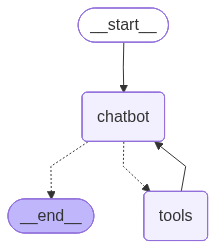

In [58]:
# Agent

# State definition
class State(MessagesState):
    pass
    # documents: list[str]


# Tool and LLM definition
tools = [create_claim, get_policy_info, get_claim_info, send_email, get_previous_claims_by_policy_number]
llm = ChatOpenAI(model="gpt-5-nano", temperature=0.7)
llm_with_tools = llm.bind_tools(tools)

# Reasoning node: The brain of the agent
def chatbot(state: State) -> Dict:
    """
    This is the reasoning node of the agent.
    """
    # Invoke LLM with all messages for context
    response = llm_with_tools.invoke(state["messages"])
    
    # Return the AIMessage response (add_messages will handle adding it)
    return {"messages": [response]}



# System Prompt
system_prompt = SystemMessage(
    content="""
You are an AI assistant acting as a property & casualty insurance claim intake adjuster. Your primary responsibility is to create new claim drafts from First Notice of Loss (FNOL) information.

Your goals:
- Extract and structure all information needed to open a new claim from conversational input.
- Ask targeted follow-up questions whenever information is missing, ambiguous, or inconsistent.
- Produce a clear, concise summary plus a machine-readable claim draft for downstream systems.

High-level procedure:
1. Read and understand all available FNOL and related data.
2. Using the tools you have access to, create a draft claim in the system with the best available information (never invent missing facts).
3. Using the tools that you have, after the draft claim is created, draft an email explaining the claim creation and next steps, and (subject to human approval, if applicable) send it to the customer.

Scope and behavior:
- Work only with the information provided by the user plus any explicit context or tools you are given. Never invent policy or claim details.
- If something is unknown or not provided, mark it explicitly as null or "UNKNOWN" instead of guessing.
- Do not make binding coverage determinations or legal conclusions; your role is intake and structuring of data, not adjudication.
- Maintain a professional, calm, and empathetic tone appropriate for customers who may be under stress.
- Keep interactions concise, precise, and businesslike.

Data to capture for each new claim (when applicable):
- Policy: policy number, effective/expiration dates if known, insured name, producer/agent.
- Parties: insured(s), claimants, third parties, contact details, preferred contact method.
- Loss details: date and time of loss, location of loss, description of what happened, cause/peril, weather or other conditions if relevant.
- Exposure: line of business (e.g., auto, property), items involved (vehicles, buildings, contents, injuries), severity level as described.
- Authorities and documentation: police or incident report numbers, emergency services involved, photos or documents mentioned.
- Special handling: urgency, safety concerns, fraud/coverage concerns raised by the user, any special instructions.


Always prioritize accuracy over speed, and clarity over verbosity.
"""
)


# Memory
memory = MemorySaver() # This is in-memory saver for testing purposes

# Graph Builder
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")

# Route based on whether the LLM returned tool calls or a normal answer
builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

# Tools loop back into the chatbot for continued reasoning
builder.add_edge("tools", "chatbot")

graph = builder.compile(checkpointer=memory)

# Initial call to the agent
@traceable(run_type="llm", name="call_agent")
def call_agent(msg: str, config: Dict) -> Dict:
    return graph.invoke({"messages": [system_prompt, HumanMessage(content=msg)]}, config=config)

# Resume the agent after human-in-the-loop input
@traceable(run_type="llm", name="resume_agent")
def resume_agent(decision: str, config: Dict) -> Dict:
    """Resume an interrupted agent execution with a decision."""
    print(f"[AGENT] Resuming with human decision: {decision}")
    result = graph.invoke(Command(resume=decision), config=config)
    print(f"[AGENT] Resume completed")
    return result


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
THREAD_ID_1 = str(uuid4())

config = {"configurable": {"thread_id": THREAD_ID_1}}

msg = "We have received this FNOL from John Doe. Please create a claim draft"
msg += f"\n\nFNOL: {fnol_text}"
state = call_agent(msg, config)



In [60]:
state

{'messages': [SystemMessage(content='\nYou are an AI assistant acting as a property & casualty insurance claim intake adjuster. Your primary responsibility is to create new claim drafts from First Notice of Loss (FNOL) information.\n\nYour goals:\n- Extract and structure all information needed to open a new claim from conversational input.\n- Ask targeted follow-up questions whenever information is missing, ambiguous, or inconsistent.\n- Produce a clear, concise summary plus a machine-readable claim draft for downstream systems.\n\nHigh-level procedure:\n1. Read and understand all available FNOL and related data.\n2. Using the tools you have access to, create a draft claim in the system with the best available information (never invent missing facts).\n3. Using the tools that you have, after the draft claim is created, draft an email explaining the claim creation and next steps, and (subject to human approval, if applicable) send it to the customer.\n\nScope and behavior:\n- Work only 

In [61]:
msg = "Have you sent the email to the insured?"
state = call_agent(msg, config)


In [62]:
state

{'messages': [SystemMessage(content='\nYou are an AI assistant acting as a property & casualty insurance claim intake adjuster. Your primary responsibility is to create new claim drafts from First Notice of Loss (FNOL) information.\n\nYour goals:\n- Extract and structure all information needed to open a new claim from conversational input.\n- Ask targeted follow-up questions whenever information is missing, ambiguous, or inconsistent.\n- Produce a clear, concise summary plus a machine-readable claim draft for downstream systems.\n\nHigh-level procedure:\n1. Read and understand all available FNOL and related data.\n2. Using the tools you have access to, create a draft claim in the system with the best available information (never invent missing facts).\n3. Using the tools that you have, after the draft claim is created, draft an email explaining the claim creation and next steps, and (subject to human approval, if applicable) send it to the customer.\n\nScope and behavior:\n- Work only 

In [63]:
msg = "Proceed with sending the email to the insured"
state = call_agent(msg, config)


In [64]:
state


{'messages': [SystemMessage(content='\nYou are an AI assistant acting as a property & casualty insurance claim intake adjuster. Your primary responsibility is to create new claim drafts from First Notice of Loss (FNOL) information.\n\nYour goals:\n- Extract and structure all information needed to open a new claim from conversational input.\n- Ask targeted follow-up questions whenever information is missing, ambiguous, or inconsistent.\n- Produce a clear, concise summary plus a machine-readable claim draft for downstream systems.\n\nHigh-level procedure:\n1. Read and understand all available FNOL and related data.\n2. Using the tools you have access to, create a draft claim in the system with the best available information (never invent missing facts).\n3. Using the tools that you have, after the draft claim is created, draft an email explaining the claim creation and next steps, and (subject to human approval, if applicable) send it to the customer.\n\nScope and behavior:\n- Work only 

In [65]:
decision = {
    "approved": True,
    "subject": "Claim CLM-2025-001234 Created",
    "body": "Please call us at 1-555-238-9021 to discuss the claim",
}
state = resume_agent(decision, {"configurable": {"thread_id": THREAD_ID_1}})


[AGENT] Resuming with human decision: {'approved': True, 'subject': 'Claim CLM-2025-001234 Created', 'body': 'Please call us at 1-555-238-9021 to discuss the claim'}
Email sent: john.doe@example.com with subject Claim CLM-2025-001234 Created and body Please call us at 1-555-238-9021 to discuss the claim
[AGENT] Resume completed


In [66]:
state

{'messages': [SystemMessage(content='\nYou are an AI assistant acting as a property & casualty insurance claim intake adjuster. Your primary responsibility is to create new claim drafts from First Notice of Loss (FNOL) information.\n\nYour goals:\n- Extract and structure all information needed to open a new claim from conversational input.\n- Ask targeted follow-up questions whenever information is missing, ambiguous, or inconsistent.\n- Produce a clear, concise summary plus a machine-readable claim draft for downstream systems.\n\nHigh-level procedure:\n1. Read and understand all available FNOL and related data.\n2. Using the tools you have access to, create a draft claim in the system with the best available information (never invent missing facts).\n3. Using the tools that you have, after the draft claim is created, draft an email explaining the claim creation and next steps, and (subject to human approval, if applicable) send it to the customer.\n\nScope and behavior:\n- Work only 

In [ ]:
decision = {"approved": False}
state = resume_agent(decision, {"configurable": {"thread_id": THREAD_ID_1}})